In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
import plotly_express as px

#### Visualizations for votes in Rio Grande do Sul in 2022

In [38]:
df = pd.read_csv(r"CSV/votacao_secao_2022_BR.csv", encoding="Latin 1", sep=";")
df.columns

Index(['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO',
       'NM_TIPO_ELEICAO', 'NR_TURNO', 'CD_ELEICAO', 'DS_ELEICAO', 'DT_ELEICAO',
       'TP_ABRANGENCIA', 'SG_UF', 'SG_UE', 'NM_UE', 'CD_MUNICIPIO',
       'NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'CD_CARGO', 'DS_CARGO',
       'NR_VOTAVEL', 'NM_VOTAVEL', 'QT_VOTOS', 'NR_LOCAL_VOTACAO',
       'SQ_CANDIDATO', 'NM_LOCAL_VOTACAO', 'DS_LOCAL_VOTACAO_ENDERECO'],
      dtype='object')

In [41]:
df_nome_locais = df[['NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO','NR_LOCAL_VOTACAO','NM_LOCAL_VOTACAO', 'DS_LOCAL_VOTACAO_ENDERECO']].drop_duplicates()
df_nome_locais.to_csv('CSV/NomesLocais.csv')

In [22]:
geocoded_df = pd.read_csv("CSV/geocoded_voting_places_001.csv")

In [5]:
df_lat_long = df.merge(geocoded_df, on = ['CD_MUNICIPIO', 'NR_ZONA', 'NR_LOCAL_VOTACAO'], how = 'left')

In [25]:
df_turno2_pres_rs_poa = df_lat_long[
    (df_lat_long['NR_TURNO']==2)&
    # (df_lat_long['NM_MUNICIPIO']=='PORTO ALEGRE')&
    (df_lat_long['SG_UF']=='RS')&
    (df_lat_long['DS_CARGO']=='PRESIDENTE')&
    ((df_lat_long['NM_VOTAVEL']=='LUIZ INÁCIO LULA DA SILVA')|(df_lat_long['NM_VOTAVEL']=='JAIR MESSIAS BOLSONARO'))
    ][['NR_ZONA','NM_VOTAVEL','QT_VOTOS','NR_LATITUDE','NR_LONGITUDE','NM_LOCAL_VOTACAO']].groupby(by=
    ['NR_LATITUDE','NR_LONGITUDE','NR_ZONA','NM_VOTAVEL','NM_LOCAL_VOTACAO']).sum('QT_VOTOS')


In [29]:
df_turno2_pres_rs_poa_pivot = pd.pivot_table(df_turno2_pres_rs_poa, values = 'QT_VOTOS', index=['NR_LATITUDE','NR_LONGITUDE','NR_ZONA','NM_LOCAL_VOTACAO'], columns = 'NM_VOTAVEL').reset_index()
df_turno2_pres_rs_poa_pivot['difference'] = df_turno2_pres_rs_poa_pivot['LUIZ INÁCIO LULA DA SILVA']-df_turno2_pres_rs_poa_pivot['JAIR MESSIAS BOLSONARO']
df_turno2_pres_rs_poa_pivot['size'] = df_turno2_pres_rs_poa_pivot['difference'].abs()

df_turno2_pres_rs_poa_pivot.dropna(inplace=True)

In [30]:
long = df_turno2_pres_rs_poa_pivot['NR_LONGITUDE']
lat =  df_turno2_pres_rs_poa_pivot['NR_LATITUDE']
geometry = [Point(xy) for xy in zip(long,lat)]
geo_df = gpd.GeoDataFrame(geometry = geometry)
geo_df['size'] = df_turno2_pres_rs_poa_pivot['size']
geo_df['diff'] = df_turno2_pres_rs_poa_pivot['difference']
geo_df['NR_ZONA'] = df_turno2_pres_rs_poa_pivot['NR_ZONA']
geo_df['size_s'] = geo_df['size']/5 

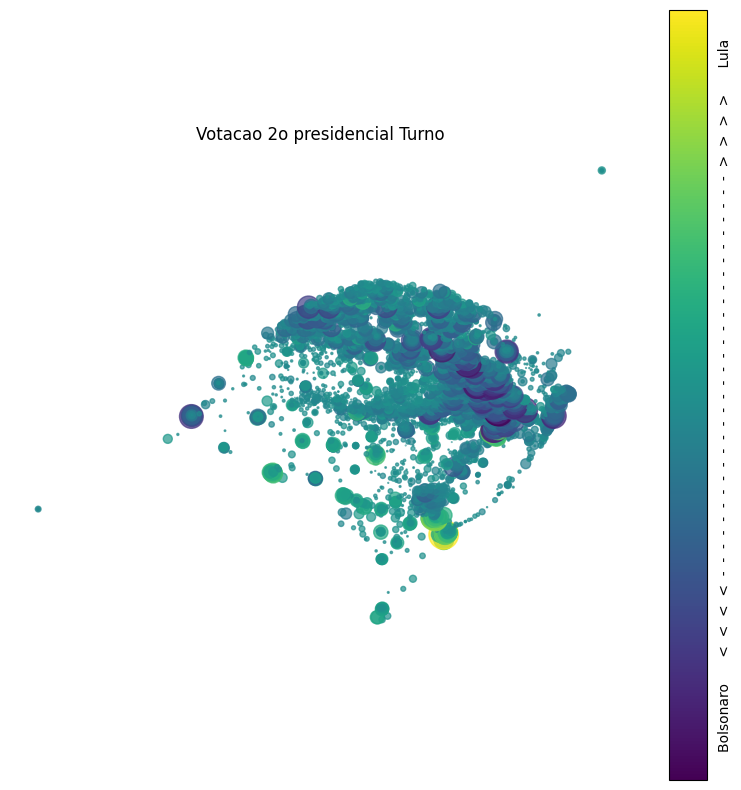

In [31]:
poa_map = gpd.read_file('Shapefiles/Zonas_Poa.shp')

fig, ax = plt.subplots()
axa = poa_map.plot(ax=ax, color='lightgray', edgecolor='grey', linewidth=0.4)
axb = geo_df.plot(ax=ax, c=geo_df['diff'], markersize='size_s', alpha=0.7, categorical=False, legend=True )
mappable = ax.collections[0]
fig.colorbar(mappable=mappable, ticks=[], label='Bolsonaro      <  <  <  <  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  >  >  >  >      Lula')
fig.set_figheight(10)
fig.set_figwidth(10)
plt.title('Votacao 2o presidencial Turno')
plt.axis('off')
plt.show()

In [34]:
df_turno2_pres_rs_poa_pivot['total_v'] = df_turno2_pres_rs_poa_pivot['JAIR MESSIAS BOLSONARO']+df_turno2_pres_rs_poa_pivot['LUIZ INÁCIO LULA DA SILVA']

In [37]:
lat_foc = -30.11
lon_foc = -51.15
fig = px.scatter_mapbox(df_turno2_pres_rs_poa_pivot,lat="NR_LATITUDE",
    lon="NR_LONGITUDE",size='total_v',color='difference', custom_data=['NR_ZONA', 'NM_LOCAL_VOTACAO', 'difference', 'total_v']).update_layout(mapbox={"style": "carto-positron", "zoom": 4}, margin={"t":0,"b":0,"l":0,"r":0})
fig.update_traces(
    hovertemplate="<br>".join([
        "Zona: %{customdata[0]}",
        "Local: %{customdata[1]}",
        "Diferenca: %{customdata[2]}",
        "Total Votos: %{customdata[3]}"
    ])
)

fig.show()

In [ ]:
df[(df['NM_LOCAL_VOTACAO']=='ESCOLA ESTADUAL APELES PORTO ALEGRE' )&
    (df['NR_TURNO']==2)&
    (df['DS_CARGO']=='PRESIDENTE')&
    ((df['NM_VOTAVEL']=='LUIZ INÁCIO LULA DA SILVA')|(df['NM_VOTAVEL']=='JAIR MESSIAS BOLSONARO'))
    ][['NR_ZONA','NM_VOTAVEL','QT_VOTOS','NM_LOCAL_VOTACAO']].groupby(by=
    ['NR_ZONA','NM_VOTAVEL','NM_LOCAL_VOTACAO']).sum('QT_VOTOS')

In [ ]:
df[(df['NM_LOCAL_VOTACAO']=='ESCOLA ESTADUAL APELES PORTO ALEGRE' )&
    (df['NR_TURNO']==1)&
    (df['DS_CARGO']=='PRESIDENTE')&
    ((df['NM_VOTAVEL']=='LUIZ INÁCIO LULA DA SILVA')|(df['NM_VOTAVEL']=='JAIR MESSIAS BOLSONARO'))
    ][['NR_ZONA','NM_VOTAVEL','QT_VOTOS','NM_LOCAL_VOTACAO']].groupby(by=
    ['NR_ZONA','NM_VOTAVEL','NM_LOCAL_VOTACAO']).sum('QT_VOTOS')

In [ ]:
df_rs= pd.read_csv('CSV/votacao_secao_2022_RS.csv', encoding="Latin 1", sep=";")

In [ ]:
df_rs.columns

In [ ]:
# df_rs[(df_rs['DS_CARGO']=='DEPUTADO ESTADUAL')&(df_rs['SG_UF']=='RS')]['NM_VOTAVEL'].unique()

In [ ]:
votos_dep = df_rs[
    (df_rs['NR_TURNO']==1)&
    (df_rs['DS_CARGO']=='DEPUTADO ESTADUAL')&
    (df_rs['NM_VOTAVEL']=='FELIPE ZORTEA CAMOZZATO')
    ][['NR_ZONA','NM_VOTAVEL','NM_MUNICIPIO','QT_VOTOS','NM_LOCAL_VOTACAO']].groupby(by=
    ['NR_ZONA','NM_MUNICIPIO','NM_LOCAL_VOTACAO']).sum('QT_VOTOS')

votos_dep

In [ ]:
df_bol = pd.read_csv('CSV/bweb_1t_RS_051020221321.csv', encoding="Latin 1", sep=";")

In [ ]:
df_bol.columns

In [ ]:
votos_dep = df_bol[
    (df_bol['NR_TURNO']==1) 
    ][['DS_TIPO_URNA','QT_VOTOS']].groupby(by=['DS_TIPO_URNA']).sum('QT_VOTOS')

votos_dep